# makes `fake_news.csv` from the raw JSON files in `politifact/`

note: you can't run this notebook without the `politifact` directory, which comes from running the script in https://github.com/KaiDMML/FakeNewsNet to download the raw JSON files.

In [1]:
import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

## loading data

In [2]:
!ls politifact/

fake real


In [3]:
!ls -l politifact/fake | head -n 10

total 0
drwxr-xr-x  3 sam  staff  96 Jul 14 14:59 politifact11773
drwxr-xr-x  3 sam  staff  96 Jul 14 14:44 politifact13038
drwxr-xr-x  3 sam  staff  96 Jul 14 14:55 politifact13467
drwxr-xr-x  3 sam  staff  96 Jul 14 14:47 politifact13468
drwxr-xr-x  3 sam  staff  96 Jul 14 15:09 politifact13475
drwxr-xr-x  3 sam  staff  96 Jul 14 14:50 politifact13484
drwxr-xr-x  3 sam  staff  96 Jul 14 15:02 politifact13496
drwxr-xr-x  3 sam  staff  96 Jul 14 14:58 politifact13501
drwxr-xr-x  3 sam  staff  96 Jul 14 14:43 politifact13515


In [4]:
from pathlib import Path

In [5]:
filename = 'news content.json'
fakes = Path('politifact/fake')
reals = Path('politifact/real')

In [6]:
import json

file = fakes / 'politifact14836' / filename
data = json.loads(file.read_text())
data.keys()

dict_keys(['url', 'text', 'images', 'top_img', 'keywords', 'authors', 'canonical_link', 'title', 'meta_data', 'movies', 'publish_date', 'source', 'summary'])

In [7]:
data['url']

'https://web.archive.org/web/20171228192703/http://houstonchronicle-tv.com/breaking-trump-fires-deputy-attorney-general-rod-rosenstein-raising-questions-over-muellers-fate/'

In [8]:
data['meta_data']['og'].get('site_name')

'Houston News'

In [9]:
import re

# we need to convert:
# 'https://web.archive.org/web/20130209000637/http://www.whitehouse.gov/state-of-the-union-2013'
# 
# into:
# 'whitehouse.gov'
archive_prefix_re = re.compile(r'https://web.archive.org/web/\d+/')
site_prefix_re = re.compile(r'(https?://)?(www\.)?')
port_re = re.compile(r':\d+')

In [10]:
def url_basename(url):
    if archive_prefix_re.match(url):
        url = archive_prefix_re.sub('', url)
    site = site_prefix_re.sub('', url).split('/')[0]
    return port_re.sub('', site)

In [18]:
def df_row(content_json, label):
    try:
        site_name = content_json['meta_data']['og']['site_name']
    except KeyError:
        site_name = None
    return {
        'url': content_json['url'],
        'text': content_json['text'],
        'title': content_json['title'],
        'publish_date': content_json['publish_date'],
        'site_name': site_name,
    }

In [19]:
def load_json(folder, label):
    filepath = folder / filename
    try:
        data = df_row(json.loads(filepath.read_text()), label)
    except FileNotFoundError:
        data = {}
    return {
        **data,
        'label': label,
        'filepath': filepath,
    }

In [20]:
def drop_nans(df):
    return df[~df['url'].isna()]

In [21]:
data['publish_date']

1451690263.0

In [22]:
df = (pd.DataFrame([load_json(path, 'fake') for path in fakes.iterdir()] +
                   [load_json(path, 'real') for path in reals.iterdir()])
      .pipe(drop_nans)
      .reset_index(drop=True)
      .assign(baseurl=lambda df: df['url'].apply(url_basename))
      .assign(timestamp=lambda df: pd.to_datetime(df['publish_date'], unit='s', errors='coerce'))
     )
df

,url,text,title,publish_date,...,label,filepath,baseurl,timestamp
0,dailybuzzlive.com/cannibals-arrested-florida/,"Police in Vernal Heights, Florida, arrested 3-...",Cannibals Arrested in Florida Claim Eating Hum...,1.62e+09,...,fake,politifact/fake/politifact14238/news content.json,dailybuzzlive.com,2021-04-05 16:39:51
1,https://web.archive.org/web/20171228192703/htt...,"WASHINGTON — Rod Jay Rosenstein, Deputy Attorn...",BREAKING: Trump fires Deputy Attorney General ...,1.45e+09,...,fake,politifact/fake/politifact14836/news content.json,houstonchronicle-tv.com,2016-01-01 23:17:43
2,https://web.archive.org/web/20160924061356/htt...,Keanu Reeves has long been known to be a stell...,Keanu Reeves Shook The World With Another POWE...,1.46e+09,...,fake,politifact/fake/politifact14207/news content.json,higherperspectives.com,2016-03-06 15:50:39
...,...,...,...,...,...,...,...,...,...
924,https://web.archive.org/web/20091016143946/htt...,Oct. 11: The debate over the best way forward ...,"Oct. 11: Levin, Graham, McCaffrey, Myers, roun...",NaN,...,real,politifact/real/politifact1255/news content.json,msnbc.msn.com,NaT
925,https://web.archive.org/web/20090701202353/htt...,"This is a rush transcript from ""On the Record,...",An Open Letter to 'All Barack Channel' - Greta...,NaN,...,real,politifact/real/politifact1067/news content.json,foxnews.com,NaT
926,https://web.archive.org/web/20130209000637/htt...,The State of the Union 2012\n\n“We can either ...,State of the Union 2013,NaN,...,real,politifact/real/politifact7390/news content.json,whitehouse.gov,NaT


In [62]:
df['timestamp'].describe(datetime_is_numeric=True)

count                              418
mean     2015-07-10 01:50:19.180459008
min                1935-07-24 05:00:00
25%                2013-07-25 01:00:00
50%         2017-02-23 05:18:13.500000
75%      2017-12-13 13:29:06.249999872
max                2022-07-13 14:49:56
Name: timestamp, dtype: object

- lots of `site_name` entries are missing
- but `baseurl` is always available and pretty accurate, so we'll use that
  as the publisher
  - this doesn't work for some sites e.g. Facebook and youtube
- `text` is empty for video/image-only posts

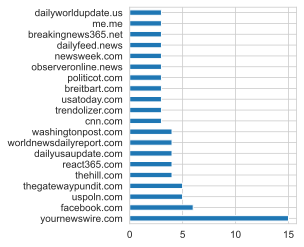

In [51]:
(df
 .query('label == "fake"')
 ['baseurl']
 .value_counts()
 .iloc[:20]
 .plot(kind='barh', figsize=(3, 4))
);

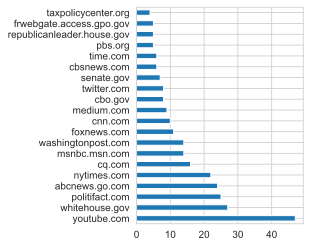

In [52]:
(df
 .query('label == "real"')
 ['baseurl']
 .value_counts()
 .iloc[:20]
 .plot(kind='barh', figsize=(3, 4))
);

## cleaning up rows

In [61]:
(df['title'] + df['text']).iloc[529]

'JavaScript is not available.\n\nWe’ve detected that JavaScript is disabled in this browser. Please enable JavaScript or switch to a supported browser to continue using twitter.com. You can see a list of supported browsers in our Help Center.\n\nHelp Center'

In [53]:
def remove_youtube(df):
    return df.query('baseurl != "youtube.com"')

def remove_empty_articles(df):
    content = (df['title'] + df['text']).str.strip()
    return df[content != '']

def subset(df):
    return df[['baseurl', 'title', 'text', 'label']]

In [54]:
df = (df.pipe(remove_youtube)
      .pipe(remove_empty_articles)
      .pipe(subset)
      .reset_index(drop=True))
df

,baseurl,title,text,label
0,dailybuzzlive.com,Cannibals Arrested in Florida Claim Eating Hum...,"Police in Vernal Heights, Florida, arrested 3-...",fake
1,houstonchronicle-tv.com,BREAKING: Trump fires Deputy Attorney General ...,"WASHINGTON — Rod Jay Rosenstein, Deputy Attorn...",fake
2,higherperspectives.com,Keanu Reeves Shook The World With Another POWE...,Keanu Reeves has long been known to be a stell...,fake
...,...,...,...,...
824,msnbc.msn.com,"Oct. 11: Levin, Graham, McCaffrey, Myers, roun...",Oct. 11: The debate over the best way forward ...,real
825,foxnews.com,An Open Letter to 'All Barack Channel' - Greta...,"This is a rush transcript from ""On the Record,...",real
826,whitehouse.gov,State of the Union 2013,The State of the Union 2012\n\n“We can either ...,real


In [55]:
df.to_csv('fake_news.csv', index=False)

In [56]:
!ls -lh fake_news.csv

-rw-r--r--  1 sam  staff   6.4M Jul 19 16:42 fake_news.csv
